# Data Structures for Punk Images

In [1]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision
import torchvision.transforms.functional as F
import PIL

In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), 'firepunks'))

from firepunks import datasets as DS
from firepunks import images as I

In [3]:
PUNK_LABELS = 'data/punks.json'
IMG_DIR = 'data/images'

PUNK_ID = 42
PUNK_IMG_PATH = 'data/images/punk0042.png'

# CPunks Format

This project is converting the CPunks-10k project to pytorch, so we'll start with implementing things the same way.

In [4]:
punks_df = DS.load_labels_df(PUNK_LABELS)

filter = ['wildHair']
labels = np.array(punks_df[filter])
data = np.array([I.load_mpimg(row) for row in range(len(labels))])

print(data.shape)
print(type(data))

(10000, 24, 24, 4)
<class 'numpy.ndarray'>


CPunks uses matplotlib's `imread` to load images. The data is structured such that there are 24x24 pixels, which each have 4 channels for RGBA: `(Height, Width, Channels)`

In [5]:
print(len(data[0]), len(data[0][0]), len(data[0][0][0]))

24 24 4


## Show one punk

In [6]:
def show_punk(pid):
    img = data[pid]
    plt.imshow(img)
    plt.title(f'Punk #{pid}')
    plt.axis('off')
    plt.show()

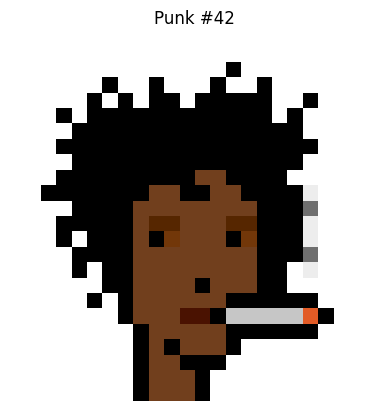

In [7]:
PUNK_ID = 42

show_punk(PUNK_ID)

## Show a grid of punks

In [8]:

def show_punks(pids, max_cols=5):
    pids = pids.copy()
    num_punks = len(pids)
    rows = 1
    cols = num_punks
    if num_punks > max_cols:
        rows = math.ceil(num_punks / max_cols)
        cols = max_cols
    _, ax = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
    for i in range(rows):
        for j in range(cols):
            ax[i,j].axis('off')
            if len(pids) > 0:
                idx = pids.pop(0)
                img = data[idx]
                ax[i,j].imshow(img)
                ax[i,j].set_title(f'Punk #{idx}')
    plt.tight_layout()
    plt.show()


Plot 12 random punks

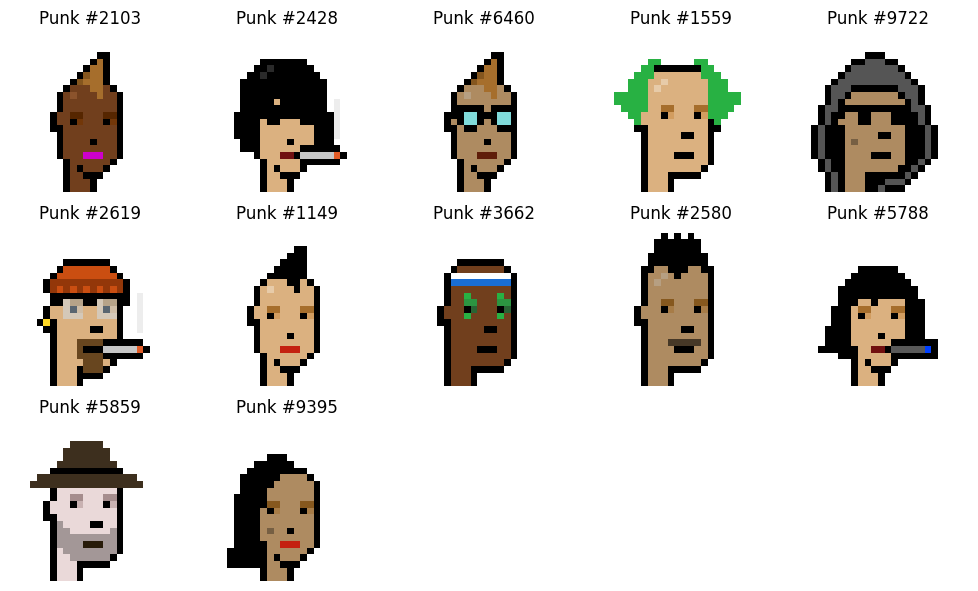

In [9]:

pids = [random.randint(0, len(data)) for c in range(12)]

show_punks(pids)

# Image Formats

MPL and Torchvision think about image structures differently. MPL stores the 24x24 pixel grid before the 4 color channels, eg. RGBA. Torch stores the grid after the color channels.

In short:
* MPL: `(Height, Width, Channels)`
* Torch: `(Channels, Height, Width)`

We plot images with MPL but the algorithms use Torch, so we must reconcile this.

## Matplotlib

We'll start with an image loaded with matplotlib. Notice the 4 channels for RGBA come after the 24x24 pixel grid.

In [10]:
m_img = mpimg.imread(PUNK_IMG_PATH)

print("matplotlib puts color channels last")
print(len(m_img), len(m_img[0]), len(m_img[0][0]))

matplotlib puts color channels last
24 24 4


No change necessary for plotting.

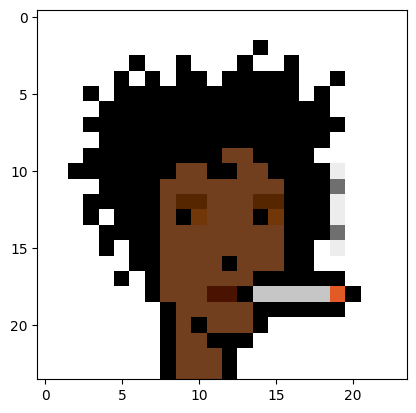

In [11]:
plt.imshow(m_img)

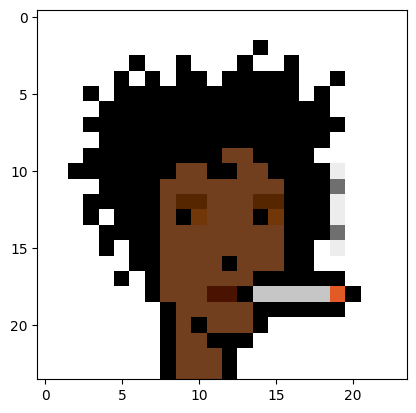

In [12]:
plt.imshow(m_img)

## Torchvision

Now we'll load the same image with Torch. Notice the 4 channels are before the 24x24 grid.

In [13]:
t_img = torchvision.io.read_image(PUNK_IMG_PATH)

print("torchvision puts color channels first")
print(len(t_img), len(t_img[0]), len(t_img[0][0]))


torchvision puts color channels first
4 24 24


We cannot plot the data in this format

ERROR: data is in torchvision format!


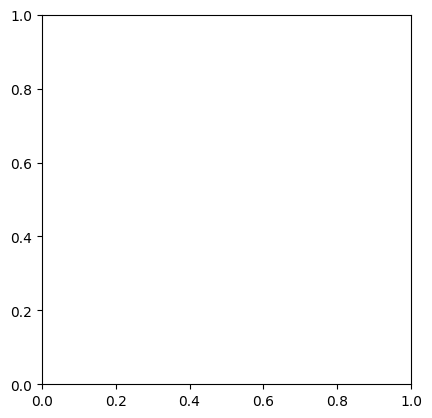

In [14]:
try:
    plt.imshow(t_img)
except:
    print("ERROR: data is in torchvision format!")

We can address that by converting the data to PIL format.

(24, 24)


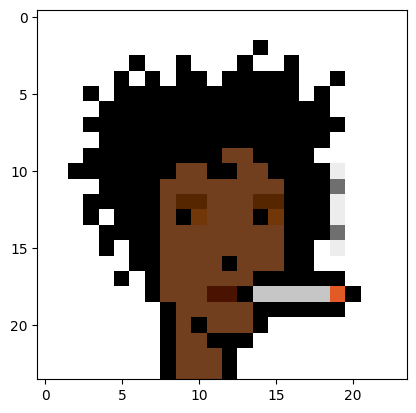

In [15]:
pil_img = F.to_pil_image(t_img)
print(pil_img.size)

# plt.imshow(tt_img)
plt.imshow(pil_img)

From Torch to PIL to matplotlib

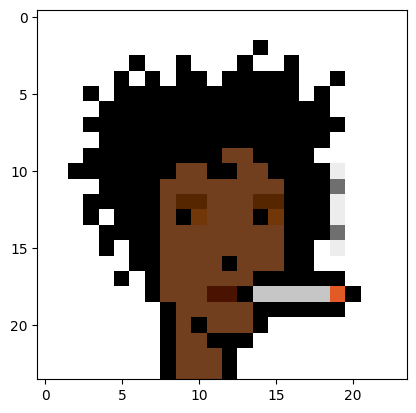

In [16]:
t_img = torchvision.io.read_image(PUNK_IMG_PATH)

pil_img = F.to_pil_image(t_img)
mm_img = mpimg.pil_to_array(pil_img)
mm_img

plt.imshow(mm_img)


In [17]:
png = PIL.Image.open(PUNK_IMG_PATH).convert('RGBA')
background = PIL.Image.new('RGBA', png.size, (255,255,255))

rgba_comp = PIL.Image.alpha_composite(background, png)
# alpha_composite.save('foo.jpg', 'JPEG', quality=80)

rgb_comp = rgba_comp.convert('RGB')
comp_tensor = F.pil_to_tensor(rgb_comp)

torchvision.io.write_png(comp_tensor, '32.png')